# Exploring Model For Pollen Count

In this notebook, we will perform data preprocessing for the pollen count data. We will also apply feature selection methods on the dataset. We will try several regression models to compare and discuss the most reasonable and appropriate model.

In [1]:
import pickle
import datetime
import pandas as pd
import numpy as np

# visulization
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# model
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_regression, f_classif, mutual_info_regression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor, plot_importance

#metrics 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score

import math
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('backup_data_preprocessed.csv')

In [3]:
df

grass_count    av_abl_ht  accum_prcp  av_lwsfcdown        av_mslp  \
0             0.0   753.565000    0.000156    293.490000  101769.360000   
1             0.0   882.295000    0.011341    340.160000  101239.120000   
2             0.0   642.775000    0.241001    354.760625  101026.800000   
3             0.0   850.585000    0.021159    332.816250  101789.000000   
4             0.0   772.685000    0.006436    339.945000  101948.000000   
...           ...          ...         ...           ...            ...   
7659        119.0  1261.250000    0.000679    336.648331  100953.083333   
7660         52.0  1430.958333    0.188170    373.324172  100712.875000   
7661          2.0  1519.916667    0.001351    339.529167  101467.833333   
7662          9.0   901.160000    0.000091    311.778802  101782.160000   
7663         14.0   808.920000    0.004603    353.954401  101928.720000   

      av_qsair_scrn  av_swsfcdown  av_temp_scrn  av_uwnd10m  av_vwnd10m  ...  \
0          0.006113    411.645000    289.752500   -0.855000    4.340000  ...   
1          0.007275    333.087500    294.993125    0.780000   -1.270000  ...   
2          0.008047    274.170000    289.227500    3.050000    4.835000  ...   
3          0.006387    309.916250    287.412500    3.655000    7.555000  ...   
4          0.007227    344.033125    289.284375    0.785000    5.965000  ...   
...             ...           ...           ...         ...         ...  ...   
7659       0.006370    382.160006    297.887499    0.433333   -0.908333  ...   
7660       0.006539    132.561667    292.519165    1.533333    1.174999  ...   
7661       0.004866    224.656248    288.478748    0.158333    3.708333  ...   
7662       0.007105    372.794401    291.002400   -0.416000    3.292000  ...   
7663       0.008712    297.748395    291.171202    0.072000    4.372000  ...   

      thermal_time_90D  thermal_time_180D  soil_mois_1D  soil_mois_10D  \
0             6.375000           6.375000   2343.648438    2721.484375   
1            13.000000          13.000000   2341.230469    4969.046875   
2            17.375000          17.375000   2340.359375    7215.773438   
3            20.250000          20.250000   2339.445312    9461.621094   
4            23.000000          23.000000   2338.539062   11706.601562   
...                ...                ...           ...            ...   
7659        160.599976         677.124481   7703.592438   77705.041809   
7660        158.274963         679.274445   7701.629913   77707.999268   
7661        157.250061         679.508850   7698.877380   77387.521759   
7662        159.399963         683.230713   8008.187408   77700.604279   
7663        157.824890         686.483765   7999.360016   77683.759460   

      soil_mois_30D  soil_mois_90D  soil_mois_180D        date  year    train  
0       2721.484375    2721.484375     2721.484375  2000-01-02  2000  2000-01  
1       4969.046875    4969.046875     4969.046875  2000-01-03  2000  2000-01  
2       7215.773438    7215.773438     7215.773438  2000-01-04  2000  2000-01  
3       9461.621094    9461.621094     9461.621094  2000-01-05  2000  2000-01  
4      11706.601562   11706.601562    11706.601562  2000-01-06  2000  2000-01  
...             ...            ...             ...         ...   ...      ...  
7659  232021.048706  671973.964569   754149.210911  2020-12-27  2020  2020-12  
7660  231986.591095  679675.594482   760968.803474  2020-12-28  2020  2020-12  
7661  231623.476013  687053.616882   767469.413036  2020-12-29  2020  2020-12  
7662  231889.883423  695061.804291   774604.499500  2020-12-30  2020  2020-12  
7663  231836.275970  695957.374298   781405.386192  2020-12-31  2020  2020-12  

[7664 rows x 175 columns]

In [4]:
corr_cols = df.columns.to_list()
corr = df[corr_cols].corr()
# avergae correlation with grass count
# remove last one since it is the correlation with itself = 1
feature_corr = corr['grass_count'][:-1]

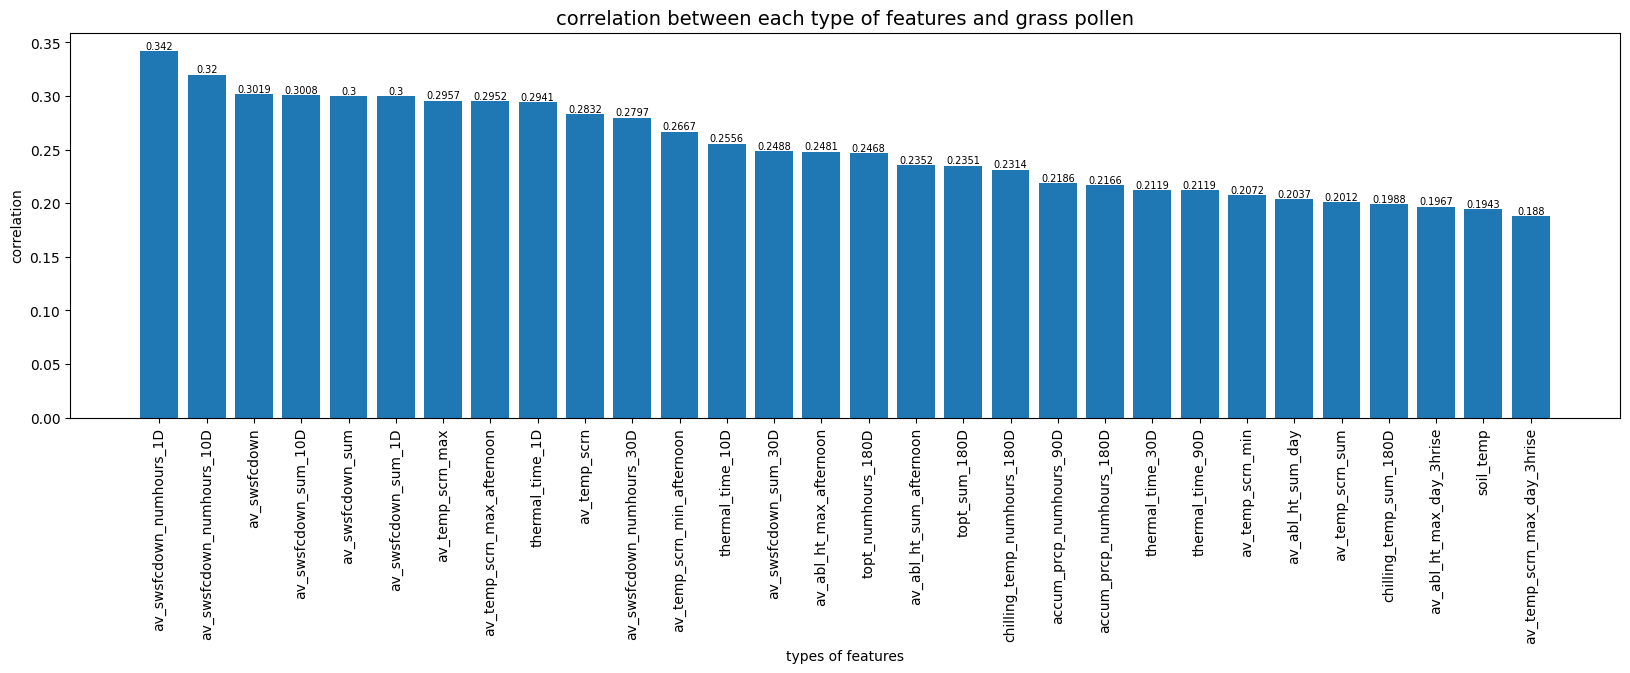

In [24]:
# sort the dictionary of correlation
sorted_corr = sorted(feature_corr.items(), key=lambda item: item[1], reverse = True)

# correlation plot for top 50 feature
select_corr = sorted_corr[1:31]
plt.figure(figsize=(20,5))
x = list(x[0] for x in select_corr)
y = list(round(x[1],4) for x in select_corr)
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title("correlation between each type of features and grass pollen", fontsize=14)
plt.ylabel("correlation")
plt.xlabel("types of features")
for a, b in zip(x, y):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)
plt.show()

## Modelling
### Dataset
- We have 172 variables in total.</br>
- The numerical target variable is 'grass count'.
- We decide to use dataset from 2000 to 2019 as our training dataset.
- And the rest of the data are testing dataset, i.e., data of 2020 and 2021 (2020-10-02 to 2021-01-31)


#### <font color=Blue> Regression Model. LightBM Regressor</font>

<b>LightGBM is a gradient boosting framework that uses tree based learning algorithm.</b>

- Splits: LightGBM offers gradient-based one-side sampling (GOSS) that selects the split using all the instances with large gradients (i.e., large error) and a random sample of instances with small gradients. In order to keep the same data distribution when computing the information gain, GOSS introduces a constant multiplier for the data instances with small gradients. Thus, GOSS achieves a good balance between increasing speed by reducing the number of data instances and keeping the accuracy for learned decision trees. This method is not the default method for LightGBM, so it should be selected explicitly.

- Leaf growth: LightGBM uses leaf-wise (best-first) tree growth. It chooses to grow the leaf that minimizes the loss, allowing a growth of an imbalanced tree. Because it doesn’t grow level-wise, but leaf-wise, overfitting can happen when data is small. In these cases, it is important to control the tree depth. </br>

<i>ref: https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc </i>

*** *** 


#### LightGBM Model1: use all features for prediction - Baseline
Now, we need to split the dataset for training and testing.

In [6]:
#training dataset
train_data = df.loc[(df['train'] != '2020-12') & (df['train'] != '2020-10')& (df['train'] != '2020-11')]

# plot
train_data_plot = train_data.copy()
train_data_plot['date'] = train_data_plot['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
train_data_plot.index = train_data_plot['date']

X_train = train_data.drop(['grass_count', 'year', 'date', 'train'], axis = 1).reset_index(drop = True)
y_train = train_data['grass_count']
print(X_train.shape)
print(y_train.shape)

(7573, 171)
(7573,)


In [7]:
# testing dataset
test_data = df.loc[(df['train'] == '2020-12') | (df['train'] == '2020-10') |(df['train'] == '2020-11')]

# plot
test_data_plot = test_data.copy()
test_data_plot['date'] = test_data_plot['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
test_data_plot.index = test_data_plot['date']

X_test = test_data.drop(['grass_count', 'year', 'date', 'train'], axis = 1).reset_index(drop = True)
y_test = test_data['grass_count']
print(X_test.shape)
print(y_test.shape)

(91, 171)
(91,)


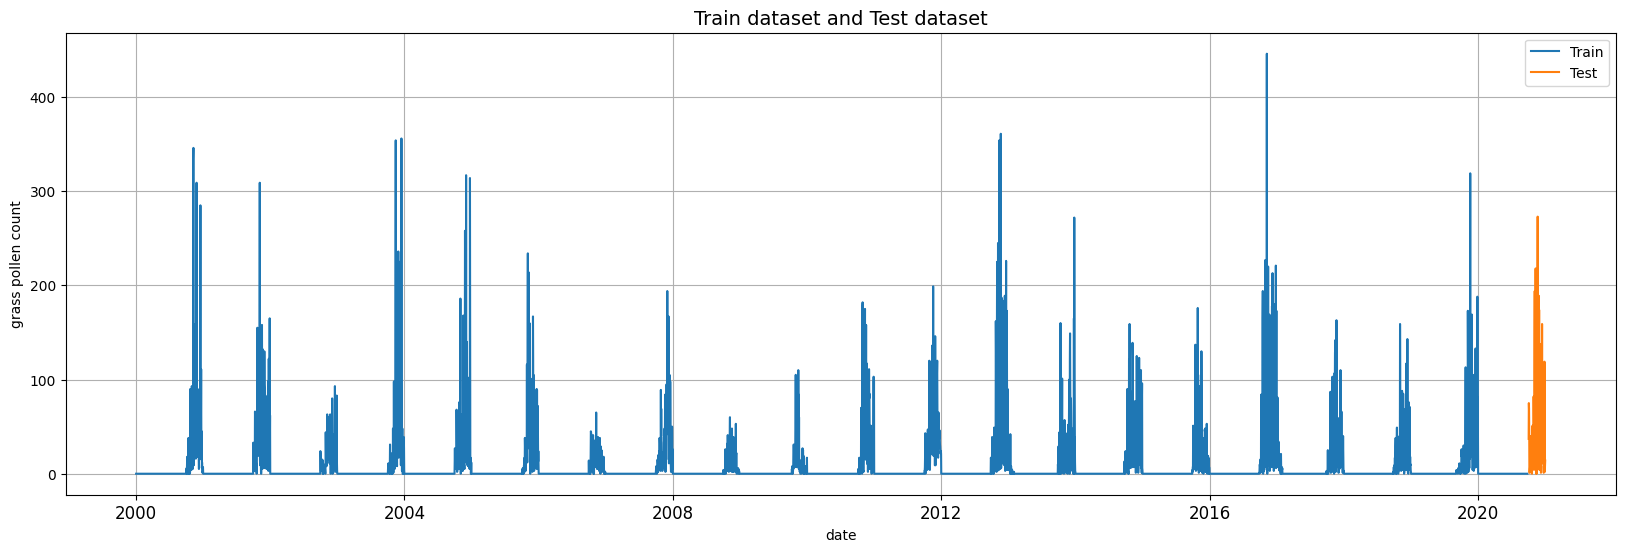

In [22]:
plt.figure(figsize=(20,6))
plt.grid()
plt.plot(train_data_plot['grass_count'], label='Train')
plt.plot(test_data_plot['grass_count'], label='Test')
plt.legend(loc='best')
plt.title('Train dataset and Test dataset', fontsize=14)
plt.xticks(fontsize=12)
plt.xlabel('date')
plt.ylabel('grass pollen count')
plt.show()

Then, we can apply LGBMRegressor on the dataset without tuning parameters as the baseline model.

In [9]:
# baseine
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

# predict
y_pred = lgbm.predict(X_test)
y_pred = np.where(y_pred<0, 0, y_pred)
# round to integer
y_pred = np.rint(y_pred)

# evaluation
print('='*25 + 'Evaluation results' + '='*25)
print('The MSE of prediction is: {}'.format(mean_squared_error(y_test, y_pred)))
print('The RMSE of prediction is: {}'.format(math.sqrt(mean_squared_error(y_test, y_pred))))
print('The R2 score of prediction is: {}'.format(r2_score(y_test, y_pred)))

=========================Evaluation results=========================
The MSE of prediction is: 2350.010989010989
The RMSE of prediction is: 48.47691191702488
The R2 score of prediction is: 0.371468108704485


In [10]:
result = pd.DataFrame(list(y_test))
result['baseline'] = list(y_pred)
result.index = list(test_data['date'])
result = result.rename(columns = {0: 'test'})
result.to_csv("result_baseline.csv")

<AxesSubplot:title={'center':'Top 20 Feature importance '}, xlabel='Feature importance', ylabel='Features'>

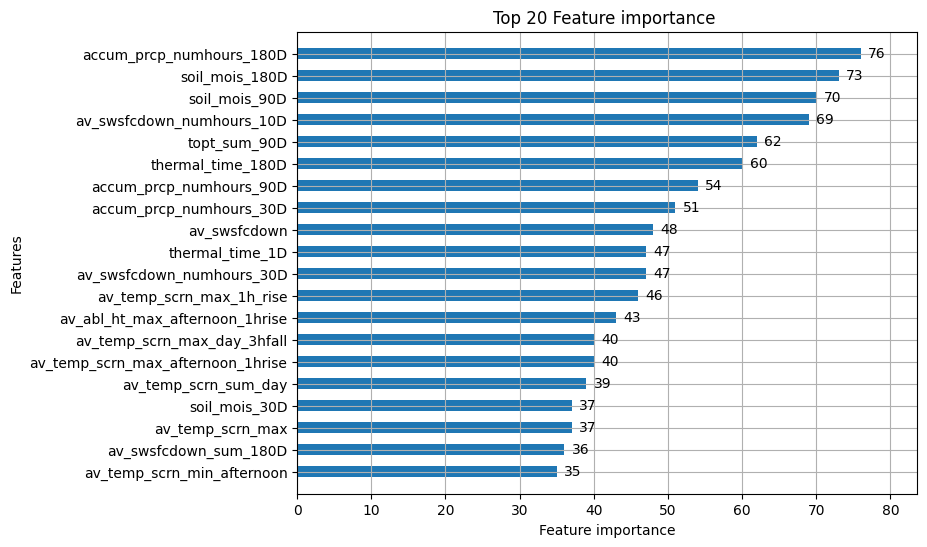

In [12]:
plot_importance(lgbm, height=.5, max_num_features=20, figsize=(8, 6), title="Top 20 Feature importance ")

In [13]:
feature_type = ['av_abl_ht', 'accum_prcp', 'av_lwsfcdown', 'av_mslp', 'av_qsair_scrn', 'av_swsfcdown', 
                'av_temp_scrn', 'av_uwnd10m', 'av_vwnd10m', 'av_wndgust10m', 'dewpt_scrn', 'soil_mois', 
                'soil_temp', 'topt', 'thermal_time', 'Wind', 'precp', 'chilling_temp', 'forcing_temp']

In [14]:
feature_imp_df = pd.DataFrame(sorted(zip(lgbm.feature_importances_, train_data.columns)), columns=['Value','Feature'])

In [15]:
def extract_df(feature, df, colnames):
    '''
    extract each type of features and grass count to a single dataframe
    '''
    all_list = list(filter(lambda x: feature in x, colnames))
    final_df = pd.DataFrame()
    for lst in all_list:
        one_df = df[df['Feature'] == lst]
        final_df = pd.concat([final_df, one_df], axis=0)

    return final_df

In [16]:
colnames = feature_imp_df['Feature'].to_list()
avg_imp_dict = {}
for feature in feature_type:
    single_df = extract_df(feature, feature_imp_df, colnames)
    avg_imp_dict[feature] = round(single_df['Value'].mean(), 4)
 

In [17]:
feature_avg_imp = pd.DataFrame.from_dict(avg_imp_dict, orient="index")
feature_avg_imp = feature_avg_imp.rename(columns = {0: 'Avg value'})
feature_avg_imp = feature_avg_imp.sort_values(by='Avg value', ascending = False)

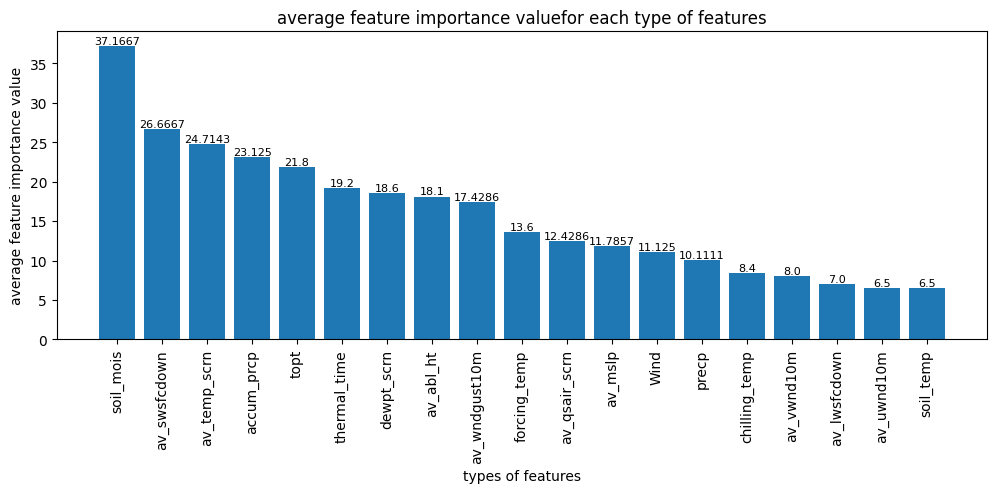

In [23]:
plt.figure(figsize=(12,4))
plt.bar(feature_avg_imp.index.to_list(), feature_avg_imp['Avg value'])
plt.xticks(rotation=90)
plt.title("average feature importance valuefor each type of features")
plt.ylabel("average feature importance value")
plt.xlabel("types of features")
for a, b in zip(feature_avg_imp.index.to_list(), feature_avg_imp['Avg value']):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
plt.show()